# Hyperparameter Optimization Using Optuna

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# Ensure optuna is installed
try:
    import optuna
except ImportError:
    print("You need to install the optuna package using pip install optuna")

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

## Setup
This is a work in progress notebook that will demonstrate how to combine automatic hyperparameter optimization using the awesome `optuna` package with BayesFlow.

Let's get started.

### Simulator and Data
First, we simulate mini training and validation data sets.

In [7]:
# Prepare simulator - using our favorite two moons
batch_size = 128
simulator = bf.benchmarks.simulators.TwoMoons()

# Prepare data dictionaries
train_samples = simulator.sample(1024)
val_samples = simulator.sample(512)

# Prepare data adapter to connect data with networks
adapter = (
    bf.adapters.Adapter()
    .rename("parameters", "inference_variables")
    .rename("observables", "inference_conditions")
)

# Prepare data sets
train_dataset = bf.datasets.OfflineDataset(
    data=train_samples, 
    batch_size=batch_size, 
    adapter=adapter
)

val_dataset = bf.datasets.OfflineDataset(
    data=val_samples, 
    batch_size=batch_size, 
    adapter=adapter
)

### Test Objective
We then define an "objective function" that will carry out the entire training and return the average validation loss over the last 5 epochs. This objective function will play the role of our "black box" function that we are going to minimize.

In [17]:
def objective(epochs=30):
    
    # Hardcode hyperparameters
    max_time = 10
    width = 256
    depth = 6
    dropout = 0.05
    initial_learning_rate = 5e-4
    
    # Create inference net
    sigma2 = keras.ops.var(train_samples["parameters"].astype("float32"), axis=0, keepdims=True)
    inference_network = bf.networks.ConsistencyModel(
        subnet_kwargs={"widths": (width,)*depth},
        total_steps=epochs*train_dataset.num_batches,
        max_time=max_time,
        sigma2=sigma2,
    )
    
    # Create optimizer
    scheduled_lr = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=epochs*train_dataset.num_batches,
        alpha=1e-8
    )
    optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)
    
    
    # Create approximator
    approximator = bf.ContinuousApproximator(
        inference_network=inference_network,
        adapter=adapter,
    )
    approximator.compile(optimizer=optimizer)
    
    # Train and compute the average of last 5 validation losses
    history = approximator.fit(
        epochs=epochs,
        dataset=train_dataset,
        validation_data=val_dataset,
        verbose=0
    )
    return np.mean(history.history["val_loss"][-5:])

In [18]:
print("Validation loss: {}".format(objective()))

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Validation loss: 0.31451714038848877


###  Optuna Objective
We now create an optuna objective that will optimize some of the parameters. The objective is the same as before, but we will train for more epochs and take the average of the last 10 validation losses

You can read more about `optuna`'s trial and study objects here:
https://optuna.readthedocs.io/en/stable/tutorial/index.html

In [21]:
def objective(trial, epochs=100):
    
    # Optimize hyperparameters
    max_time = trial.suggest_int("max_time", 1, 30)
    width = trial.suggest_int("width", 128, 512)
    depth = trial.suggest_int("depth", 2, 8)
    dropout = trial.suggest_float("dropout", 0.01, 0.5)
    initial_learning_rate = trial.suggest_float("lr", 1e-4, 1e-3) 
    
    # Create inference net
    sigma2 = keras.ops.var(train_samples["parameters"].astype("float32"), axis=0, keepdims=True)
    inference_network = bf.networks.ConsistencyModel(
        subnet_kwargs={"widths": (width,)*depth, "dropout": dropout},
        total_steps=epochs*train_dataset.num_batches,
        max_time=max_time,
        sigma2=sigma2,
    )
    
    # Create optimizer
    scheduled_lr = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=epochs*train_dataset.num_batches,
        alpha=1e-8
    )
    optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)
    
    
    # Create approximator
    approximator = bf.ContinuousApproximator(
        inference_network=inference_network,
        adapter=adapter,
    )
    approximator.compile(optimizer=optimizer)
    
    # Train and compute the average of last 5 validation losses
    history = approximator.fit(
        epochs=epochs,
        dataset=train_dataset,
        validation_data=val_dataset,
        verbose=0
    )
    return np.mean(history.history["val_loss"][-10:])

## Optimization
This will take some time...

In [22]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=42)

[I 2024-10-23 20:29:50,984] A new study created in memory with name: no-name-8fedce79-d631-428a-99f0-21b2fd7091bb
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:30:10,936] Trial 0 finished with value: 0.2781076431274414 and parameters: {'max_time': 16, 'width': 487, 'depth': 8, 'dropout': 0.08407618206861452, 'lr': 0.000996043558997382}. Best is trial 0 with value: 0.2781076431274414.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:30:30,105] Trial 1 finished with value: 0.30119574069976807 and parameters: {'max_time': 10, 'width': 397, 'depth': 8, 'dropout': 0.08842429740420331, 'lr': 0.0002496152860809169}. Best is trial 0 with value: 0.2781076431274414.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:30:40,460] Trial 2 finished with value: 0.3316212296485901 and paramet

INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:35:06,581] Trial 23 finished with value: 0.2482193261384964 and parameters: {'max_time': 26, 'width': 176, 'depth': 7, 'dropout': 0.057785640956793546, 'lr': 0.0008353358157159328}. Best is trial 15 with value: 0.23585954308509827.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:35:15,523] Trial 24 finished with value: 0.30703312158584595 and parameters: {'max_time': 27, 'width': 176, 'depth': 6, 'dropout': 0.10898778860482289, 'lr': 0.0008875112382879753}. Best is trial 15 with value: 0.23585954308509827.
INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
[I 2024-10-23 20:35:28,892] Trial 25 finished with value: 0.25223618745803833 and parameters: {'max_time': 25, 'width': 375, 'depth': 5, 'dropout': 0.06143755723772134, 'lr': 0.0005893963771896564}. Best is trial 15 with value: 0.23585954308509827.
INFO:b

In [23]:
trial = study.best_trial
print("Validation loss: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Validation loss: 0.23585954308509827
Best hyperparameters: {'max_time': 24, 'width': 358, 'depth': 6, 'dropout': 0.011485157806539359, 'lr': 0.0007856429313897751}


## Training With Best Parameters

In [24]:
# Create inference net
epochs = 100
sigma2 = keras.ops.var(train_samples["parameters"].astype("float32"), axis=0, keepdims=True)
inference_network = bf.networks.ConsistencyModel(
    subnet_kwargs={"widths": (trial.params["width"],)*trial.params["depth"], "dropout": trial.params["dropout"]},
    total_steps=epochs*train_dataset.num_batches,
    max_time=trial.params["max_time"],
    sigma2=sigma2,
)

# Create optimizer
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=trial.params["lr"],
    decay_steps=epochs*train_dataset.num_batches,
    alpha=1e-8
)
optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)


# Create approximator
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    adapter=adapter,
)
approximator.compile(optimizer=optimizer)

# Train and compute the average of last 5 validation losses
history = approximator.fit(
    epochs=epochs,
    dataset=train_dataset,
    validation_data=val_dataset,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.5660 - loss/inference_loss: 0.5660 - val_loss: 0.4609 - val_loss/inference_loss: 0.4609
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4378 - loss/inference_loss: 0.4378 - val_loss: 0.4148 - val_loss/inference_loss: 0.4148
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4134 - loss/inference_loss: 0.4134 - val_loss: 0.4250 - val_loss/inference_loss: 0.4250
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4145 - loss/inference_loss: 0.4145 - val_loss: 0.3148 - val_loss/inference_loss: 0.3148
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3950 - loss/inference_loss: 0.3950 - val_loss: 0.4395 - val_loss/inference_loss: 0.4395
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3729 - loss/inference_loss: 0.3729 - val_loss: 0.3325 - val_loss/inference_loss: 0.3325
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3508 - loss/inference_loss: 0.3508 - val_loss: 0.379

Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2680 - loss/inference_loss: 0.2680 - val_loss: 0.2748 - val_loss/inference_loss: 0.2748
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3041 - loss/inference_loss: 0.3041 - val_loss: 0.2359 - val_loss/inference_loss: 0.2359
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2683 - loss/inference_loss: 0.2683 - val_loss: 0.2485 - val_loss/inference_loss: 0.2485
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2813 - loss/inference_loss: 0.2813 - val_loss: 0.2590 - val_loss/inference_loss: 0.2590
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2713 - loss/inference_loss: 0.2713 - val_loss: 0.2769 - val_loss/inference_loss: 0.2769
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2714 - loss/inference_loss: 0.2714 - val_loss: 0.3105 - val_loss/inference_loss: 0.3105
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2778 - loss/inference_loss: 0.2778 - val_loss

Epoch 91/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2240 - loss/inference_loss: 0.2240 - val_loss: 0.2807 - val_loss/inference_loss: 0.2807
Epoch 92/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2519 - loss/inference_loss: 0.2519 - val_loss: 0.1967 - val_loss/inference_loss: 0.1967
Epoch 93/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2666 - loss/inference_loss: 0.2666 - val_loss: 0.2067 - val_loss/inference_loss: 0.2067
Epoch 94/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2526 - loss/inference_loss: 0.2526 - val_loss: 0.2070 - val_loss/inference_loss: 0.2070
Epoch 95/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2450 - loss/inference_loss: 0.2450 - val_loss: 0.2386 - val_loss/inference_loss: 0.2386
Epoch 96/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2619 - loss/inference_loss: 0.2619 - val_loss: 0.2506 - val_loss/inference_loss: 0.2506
Epoch 97/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2672 - loss/inference_loss: 0.2672 - val_loss

### Quick Validation

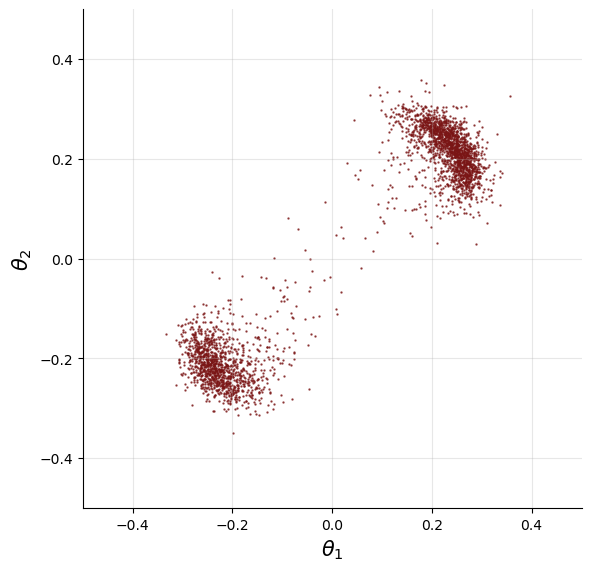

In [26]:
# Set the number of posterior draws you want to get
num_samples = 3000

# Obtain samples from amortized posterior
conditions = {"observables": np.array([[0.0, 0.0]]).astype("float32")}

# Prepare figure
f, ax = plt.subplots(1, 1, figsize=(6, 6))

# Obtain samples
samples = approximator.sample(conditions=conditions, batch_size=1, num_samples=num_samples)["parameters"]

# Plot samples
ax.scatter(samples[0, :, 0], samples[0, :, 1], color="#7a1515", alpha=0.75, s=0.5)
sns.despine(ax=ax)
ax.grid(alpha=0.3)
ax.set_aspect("equal", adjustable="box")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel(r"$\theta_1$", fontsize=15)
ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()

In [6]:
#TODO - Use a different objective